In [14]:
from IPython.display import clear_output

In [15]:
!echo "Downloading 101_Object_Categories for image notebooks"

!curl -L -o 101_ObjectCategories.zip --progress-bar https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1
!unzip 101_ObjectCategories.zip
!mv caltech-101/101_ObjectCategories.tar.gz ./101_ObjectCategories.tar.gz
!tar -xzf 101_ObjectCategories.tar.gz
!rm 101_ObjectCategories.tar.gz
!ls

clear_output()

In [16]:
import random

import torch
from torch.utils.data import Subset

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [17]:
transform = transforms.Compose([
    transforms.ToTensor(), transforms.Resize((64, 64), interpolation=transforms.InterpolationMode.NEAREST)
])

image_dataset = torchvision.datasets.ImageFolder(root='101_ObjectCategories', transform=transform)

In [18]:
print(len(image_dataset))

9144


label=0


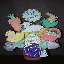

In [19]:
img, label = image_dataset[50]
print(f'{label=}')
transforms.functional.to_pil_image(img)

# Procedure:

1. Download pretrained Resnet18 model from torchhub
2. Modify the model for object 101 dataset subset (The dataset has 101 distinct classes).
3. Split the dataset between training and validation set (80% / 20%).
4. Fine tune the model for classification on the dataset.
5. Output the fine tuned model's overall accuracy on the validation set.
6. Find a way to show label wise performance/accuracy of the finetuned model.

In [20]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import math

In [21]:
batch_sz = 64
number_of_samples = len(image_dataset)
train_set, val_set = torch.utils.data.random_split(image_dataset, [math.ceil(0.8*number_of_samples), math.floor(int(0.2*number_of_samples))])
train_loader = DataLoader(train_set, batch_size = batch_sz)
test_loader = DataLoader(val_set, batch_size = batch_sz)

In [22]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

# Freeze all layers in the network
for param in model.parameters():
    param.requires_grad = False # Freezed then unfreezed

# Replace the last fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 102)

# Unfreeze parameters of the last layer
for param in model.fc.parameters():
    param.requires_grad = True

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [26]:
device = "cuda:0"
num_epochs = 10
lr = 1e-3

train_losses = []
val_losses = []
lebels_corr = [0 for i in range(102)]
lebels_len = [0 for i in range(102)]
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()  # multi-class

model = model.to(device)
print(f'Using device {device}')

Using device cuda:0


In [27]:
%%time
for epoch_no in range(num_epochs):

  #  training
  model.train()  # convert to train model. This turns out train-specific layers in the model (if you dont know about them, an example of them is dropout. more on this later)

  epoch_weighted_loss = 0
  for batch in train_loader:
    batch_X, batch_y = batch[0].to(device), batch[1].to(device)
    batch_y_probs = model(batch_X)

    loss = criterion(batch_y_probs,batch_y)

    optimizer.zero_grad()  # need to clear out gradients from previous batch
    loss.backward()  # calculate new gradients
    optimizer.step()  # update weights

    epoch_weighted_loss += (len(batch_y)*loss.item())

  epoch_loss = epoch_weighted_loss/len(train_loader.dataset)
  train_losses.append(epoch_loss)    # add loss for tracking. we'll visualize the loss trajectory later

  # testing
  model.eval()  # take model to evaluation mode. turn off train-only layers
  correctly_labelled = 0

  with torch.no_grad():  # this makes our model to NOT track gradients

    val_epoch_weighted_loss = 0

    for batch in test_loader:

      val_batch_X, val_batch_y = batch[0].to(device), batch[1].to(device)  # convert to [N, 28*28] shape where N is batch_size


      val_batch_y_probs = model(val_batch_X)

      loss = criterion(val_batch_y_probs, val_batch_y)
      val_epoch_weighted_loss += (len(val_batch_y)*loss.item())

      val_batch_y_pred = val_batch_y_probs.argmax(dim=1)  # convert probailities to labels by picking the label (index) with the highest prob
      # dim = 1 because we will apply it to only one sample for all features and take the maximum likelyhood

      correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()  # item converts tensor to float/int/list
      expected = val_batch_y_pred.tolist()
      actual = val_batch_y.tolist()
      for e, a in zip(expected, actual):
        lebels_len[e] += 1
        if e == a:
          lebels_corr[e]+=1

  val_epoch_loss = val_epoch_weighted_loss/len(test_loader.dataset)
  val_losses.append(val_epoch_loss)


  print(f'Epoch: {epoch_no}, train_loss={epoch_loss}, val_loss={val_epoch_loss}. labelled {correctly_labelled}/{len(test_loader.dataset)} correctly ({correctly_labelled/len(test_loader.dataset)*100}% accuracy)')

print(f'Training complete on device {device}. Change device variable and run again to see the difference.')


Epoch: 0, train_loss=1.7284649056512322, val_loss=1.863946696079012. labelled 1034/1828 correctly (56.564551422319475% accuracy)
Epoch: 1, train_loss=1.2469572583595347, val_loss=1.775709326470707. labelled 1073/1828 correctly (58.69803063457331% accuracy)
Epoch: 2, train_loss=1.0168968306140471, val_loss=1.746330837191325. labelled 1077/1828 correctly (58.91684901531728% accuracy)
Epoch: 3, train_loss=0.8586525508717411, val_loss=1.7434090553279518. labelled 1083/1828 correctly (59.245076586433264% accuracy)
Epoch: 4, train_loss=0.7402757627022859, val_loss=1.7535188618061057. labelled 1095/1828 correctly (59.901531728665205% accuracy)
Epoch: 5, train_loss=0.6472510482572088, val_loss=1.7727119901769792. labelled 1097/1828 correctly (60.0109409190372% accuracy)
Epoch: 6, train_loss=0.5717412129476332, val_loss=1.7977849897201004. labelled 1101/1828 correctly (60.22975929978118% accuracy)
Epoch: 7, train_loss=0.5090468773845442, val_loss=1.826267539541883. labelled 1093/1828 correctly 

In [28]:
for i in range(len(lebels_corr)):
  if lebels_len[i] != 0:
    print(f"Label: {i} accuracy = {lebels_corr[i]*100/(lebels_len[i])}%")
  else:
    print(f"Label: {i} has not been included in the testing set")

Label: 0 accuracy = 34.77917981072555%
Label: 1 accuracy = 95.15279241306638%
Label: 2 accuracy = 89.77955911823648%
Label: 3 accuracy = 63.78896882494005%
Label: 4 accuracy = 85.11979823455233%
Label: 5 accuracy = 54.94505494505494%
Label: 6 accuracy = 69.64782205746062%
Label: 7 accuracy = 0.0%
Label: 8 accuracy = 0.0%
Label: 9 accuracy = 46.49122807017544%
Label: 10 accuracy = 0.0%
Label: 11 accuracy = 34.21052631578947%
Label: 12 accuracy = 56.666666666666664%
Label: 13 accuracy = 56.630824372759854%
Label: 14 accuracy = 46.391752577319586%
Label: 15 accuracy = 13.698630136986301%
Label: 16 accuracy = 47.87234042553192%
Label: 17 accuracy = 65.38461538461539%
Label: 18 accuracy = 39.705882352941174%
Label: 19 accuracy = 16.49484536082474%
Label: 20 accuracy = 95.89041095890411%
Label: 21 accuracy = 43.54838709677419%
Label: 22 accuracy = 85.18518518518519%
Label: 23 accuracy = 18.96551724137931%
Label: 24 accuracy = 33.83233532934132%
Label: 25 accuracy = 47.82608695652174%
Label: 